#define model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend
from data_mgmt import DAO
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def model_define(drop_rate):

    model = models.Sequential()

    model.add(layers.Conv2D(
        32, (11,1), padding="same", input_shape=(720,1,1),
        name="conv_1" ))
    model.add(layers.Conv2D(
        64, kernel_size=(5,1), padding="same",
        name="conv_2" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_1" ))
    model.add(layers.Conv2D(
        256, kernel_size=(5,1), padding="same",
        name="conv_3" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=4, padding="same",
        name="pool_2" ))

    model.add(layers.Flatten())

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1024, activation="relu", name="dense_1"))

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(128, activation="relu", name="dense_2"))

    model.add(layers.Dense(3, name="dense_3"))

    return model

beta = 0.2

def pos_loss(y_actual, y_pred):
    loss_value = (1-beta)*(backend.sqrt(backend.pow((y_actual[:,0]-y_pred[:,0]),2)+backend.pow((y_actual[:,1]-y_pred[:,1]),2)))+(beta*(backend.sqrt(backend.pow((y_actual[:,2]-y_pred[:,2]),2))))
    return loss_value

In [46]:
filename="laser_log/laser_log.csv"

data = DAO(filename)

data.read()
data.divide_data(0.25)

In [3]:
model_cnn = model_define(0.2)

2022-03-17 16:00:34.573188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 16:00:34.765924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-17 16:00:34.765961: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [59]:
model_cnn.compile(optimizer = "adam",
    loss=pos_loss,
    metrics=['mean_absolute_error'])

In [60]:
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 720, 1, 32)        384       
                                                                 
 conv_2 (Conv2D)             (None, 720, 1, 64)        10304     
                                                                 
 pool_1 (MaxPooling2D)       (None, 360, 1, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 360, 1, 256)       82176     
                                                                 
 pool_2 (MaxPooling2D)       (None, 90, 1, 256)        0         
                                                                 
 flatten_6 (Flatten)         (None, 23040)             0         
                                                                 
 dropout_12 (Dropout)        (None, 23040)            

#format the data

In [41]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

#Training model

In [42]:
history = model_cnn.fit(data.TR_features, 
    data.TR_targets, 
    epochs=15, 
    validation_data=(data.TS_features, data.TS_targets)
    )


Epoch 1/15
22/22 [==============================] - 10s 420ms/step - loss: 3.7206 - mean_absolute_error: 2.3388 - val_loss: 1.4939 - val_mean_absolute_error: 0.9553
Epoch 2/15
22/22 [==============================] - 8s 373ms/step - loss: 1.9105 - mean_absolute_error: 1.1876 - val_loss: 1.6249 - val_mean_absolute_error: 1.0271
Epoch 3/15
22/22 [==============================] - 8s 375ms/step - loss: 1.3488 - mean_absolute_error: 0.8529 - val_loss: 1.2856 - val_mean_absolute_error: 0.7702
Epoch 4/15
22/22 [==============================] - 8s 347ms/step - loss: 0.9976 - mean_absolute_error: 0.6322 - val_loss: 0.9996 - val_mean_absolute_error: 0.6115
Epoch 5/15
22/22 [==============================] - 8s 342ms/step - loss: 0.8550 - mean_absolute_error: 0.5525 - val_loss: 1.3387 - val_mean_absolute_error: 0.8222
Epoch 6/15
22/22 [==============================] - 7s 333ms/step - loss: 0.9026 - mean_absolute_error: 0.5671 - val_loss: 0.8859 - val_mean_absolute_error: 0.5390
Epoch 7/15
22/2

8/8 - 1s - loss: 0.7081 - mean_absolute_error: 0.3587 - 558ms/epoch - 70ms/step


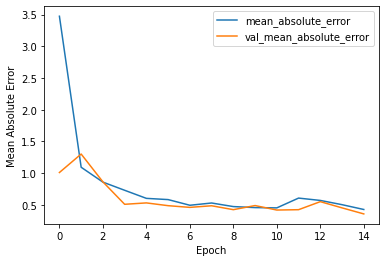

In [9]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)


8/8 - 1s - loss: 0.9760 - mean_absolute_error: 0.4660 - 857ms/epoch - 107ms/step


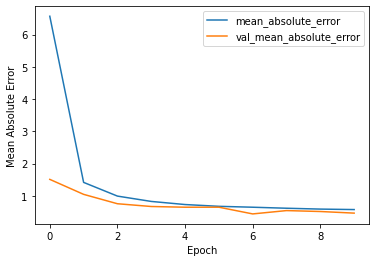

In [ ]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)


#save/load model weights

In [ ]:
checkpoint_path="models/cp-{epoch}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)


In [10]:
#save Model weights
model_cnn.save("models/cp-epoch15-23M.ckpt")

2022-03-16 17:27:21.360906: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/cp-epoch15-23M.ckpt/assets


In [ ]:
#load Model weights
model_cnn.load_weights("models/cp-epoch15-23M.ckpt")

#analysis test data

In [43]:
result = model_cnn.predict(data.TS_features)

In [44]:
pos_test = result[:,0:2]
rot_test = result[:,2]

In [ ]:
#reformat data

data.read()
data.divide_data(0.25)

In [47]:
pos_real = np.array([data.TS_targets["pos_x"].to_list(),data.TS_targets["pos_y"].to_list()]).T
rot_real = (data.TS_targets["pos_yaw"]).to_numpy()

In [48]:
pos_mse, rot_mse = 0,0

for i in range(len(pos_real)):
    pos_mse += (np.sqrt(((pos_real[i,0]-pos_test[i,0])**2)+((pos_real[i,1]-pos_test[i,1])**2)))/len(pos_test)

for i in range(len(rot_real)):
    rot_mse += np.sqrt((rot_real[i]-rot_test[0])**2)/len(rot_real)
